# Structure-based Drug Discovery

## Aim of this lab

To use a set of compounds and perform docking. 

### Objectives

* Prep ER Alpha receptor and crystalized ligand for docking
* Download _in vitro_ binding assay data and dock using SMINA


## Background


Background on QSAR

### Descriptors

Similar to calculating chemical similiarity, PCA can be done on any set of descriptors or fingerprints.  However, just like we saw before its important to standardize if your descriptors are not already on the same range.  

Reference paper that lists two ERalpha complexes used for different ligands: https://www.nature.com/articles/s41598-019-43768-5

1) 3ERT is human ERa-LBD with OHT, an active metabolite of TM.  
2) 1GWR is ERa-LBD with $E_{2}$. 

The text below writes a script that can be used by pymol to split the crystalized ligand and protein components into individual parts. 

In [1]:
import py3Dmol

Tutorial for py3DMol: https://william-dawson.github.io/using-py3dmol.html

In [2]:
with open("data/3ERT-receptor.pdb") as ifile:
    system = "".join([x for x in ifile])

In [3]:
view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Populating the interactive namespace from numpy and matplotlib


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

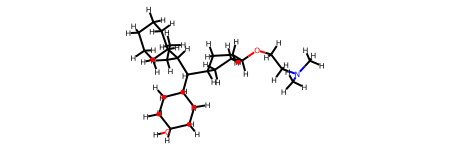

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole


%pylab inline
IPythonConsole.ipython_3d = True

mol = AllChem.MolFromPDBFile("data/3ERT-OHT.pdb")
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)
mol

Open babel to convert pdb to pdbqt, the file format necessary for SMINA.  If you have open babel install, now you would try convert using the following commands. 

```bash
obabel 3ERT-receptor.pdb -xr -O 3ERT-receptor.pdbqt
obabel 3ERT-OHT.pdb -O 3ERT-OHT.pdbqt
```

## Dock with SMINA

In [5]:
!smina -r "data/3ERT-receptor.pdbqt" -l "data/3ERT-OHT.pdbqt" --autobox_ligand "data/3ERT-OHT.pdbqt" --autobox_add 8 --exhaustiveness 16 -o "data/3ERT-OHT-redock.pdbqt"

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -193130474

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------


[CHEMBL831072](https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL831072/) measures binding affinity against the ER Alpha receptor, so we can get some compounds to try docking from there.

In [16]:
from chembl_webresource_client.new_client import new_client

# Inhibitory activity against epidermal growth factor receptor

chembl_id = "CHEMBL831072"

overview = new_client.assay.get(chembl_id)

# print assay overview
overview


{'assay_category': None,
 'assay_cell_type': None,
 'assay_chembl_id': 'CHEMBL831072',
 'assay_classifications': [],
 'assay_organism': 'Homo sapiens',
 'assay_parameters': [],
 'assay_strain': None,
 'assay_subcellular_fraction': None,
 'assay_tax_id': 9606,
 'assay_test_type': None,
 'assay_tissue': None,
 'assay_type': 'B',
 'assay_type_description': 'Binding',
 'bao_format': 'BAO_0000357',
 'bao_label': 'single protein format',
 'cell_chembl_id': None,
 'confidence_description': 'Direct single protein target assigned',
 'confidence_score': 9,
 'description': 'Binding potency for human ER alpha',
 'document_chembl_id': 'CHEMBL1137199',
 'relationship_description': 'Direct protein target assigned',
 'relationship_type': 'D',
 'src_assay_id': None,
 'src_id': 1,
 'target_chembl_id': 'CHEMBL206',
 'tissue_chembl_id': None,
 'variant_sequence': None}

In [17]:
records = new_client.activity.filter(assay_chembl_id=chembl_id)

len(records), records[:2]

(17,
 [{'activity_comment': None, 'activity_id': 1442237, 'activity_properties': [], 'assay_chembl_id': 'CHEMBL831072', 'assay_description': 'Binding potency for human ER alpha', 'assay_type': 'B', 'assay_variant_accession': None, 'assay_variant_mutation': None, 'bao_endpoint': 'BAO_0000190', 'bao_format': 'BAO_0000357', 'bao_label': 'single protein format', 'canonical_smiles': 'Oc1ccc([C@H]2Sc3cc(O)ccc3O[C@H]2c2ccc(OCCN3CCCCC3)cc2)cc1', 'data_validity_comment': None, 'data_validity_description': None, 'document_chembl_id': 'CHEMBL1137199', 'document_journal': 'Bioorg. Med. Chem. Lett.', 'document_year': 2004, 'ligand_efficiency': {'bei': '19.62', 'le': '0.38', 'lle': '3.17', 'sei': '14.63'}, 'molecule_chembl_id': 'CHEMBL304552', 'molecule_pref_name': None, 'parent_molecule_chembl_id': 'CHEMBL304552', 'pchembl_value': '9.10', 'potential_duplicate': True, 'qudt_units': 'http://www.openphacts.org/units/Nanomolar', 'record_id': 373094, 'relation': '=', 'src_id': 1, 'standard_flag': True, 

In [20]:
import pandas as pd
data = pd.DataFrame(records)
data['value'] = data['value'].astype(float)
data.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1442237,[],CHEMBL831072,Binding potency for human ER alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,0.8
1,None,1442529,[],CHEMBL831072,Binding potency for human ER alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,16.0
2,None,1442535,[],CHEMBL831072,Binding potency for human ER alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,2.0
3,None,1442541,[],CHEMBL831072,Binding potency for human ER alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,1.8
4,None,1442940,[],CHEMBL831072,Binding potency for human ER alpha,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Estrogen receptor alpha,9606,None,None,IC50,nM,UO_0000065,None,2.2


In [45]:
top_10 = data.sort_values('value')[[ 'canonical_smiles','value', 'type', 'units']].iloc[:2]

In [46]:
rdkitmols = [Chem.MolFromSmiles(cmp) for cmp in top_10.canonical_smiles]

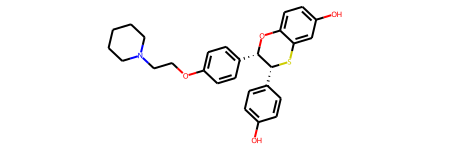

In [47]:
rdkitmols[1]

In [48]:
len(rdkitmols)

2

In [49]:
for i, mol in enumerate(rdkitmols):
    mol.SetProp('Name', f'CMP_{i}')

In [50]:
rdkitmols[0].GetProp('Name')

'CMP_0'

# Generate conformers

In [51]:
import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures


numcores = multiprocessing.cpu_count()
max_workers = numcores

# knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# this function is called in the subprocess.
# the parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh = 0.5
ps.numThreads = 0
# edit for number of confs desired eg n = 5
n = 5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids = AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]
writer = Chem.SDWriter('data/conformers.sdf')

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for i, mol in enumerate(rdkitmols):
        if mol:
            name = mol.GetProp('Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    for job in futures.as_completed(jobs):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

In [57]:
!'smina' --cpu 2 --seed 0 -r "data/3ERT-receptor.pdbqt" -l "data/conformers.sdf" --autobox_ligand "data/3ERT-OHT.pdbqt" --autobox_add 8 --exhaustiveness 16 -o "data/chembl-redock.sdf"

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -

In [74]:
from rdkit.Chem import PandasTools

docked_df = PandasTools.LoadSDF("data/chembl-redock.sdf", molColName='Molecule', removeHs=False)

,minimizedAffinity,ID,Molecule
0,-9.54904,CMP_0,
1,-9.27619,CMP_0,
2,-8.71290,CMP_0,
3,-8.66961,CMP_0,
4,-8.66263,CMP_0,
...,...,...,...
85,-9.18719,CMP_1,
86,-9.09433,CMP_1,
87,-8.86372,CMP_1,
88,-8.80628,CMP_1,

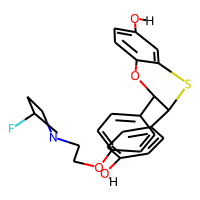
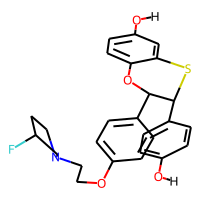
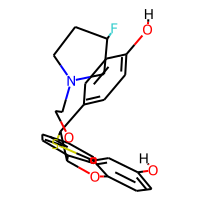
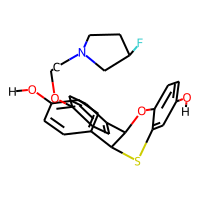
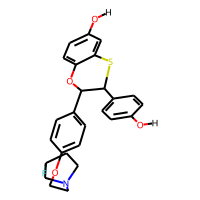
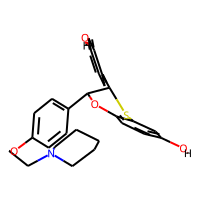
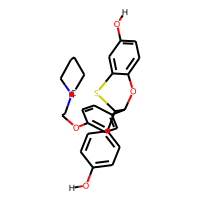
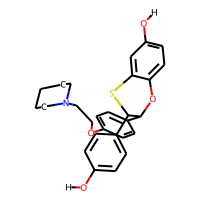
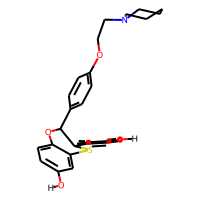
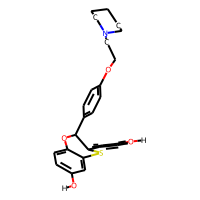

In [75]:
docked_df

In [76]:
from rdkit.Chem import rdmolops 

cp = docked_df.head(5)
# cp['Molecule'] = [rdmolops.AddHs(mol) for mol in cp.Molecule]


PandasTools.WriteSDF(cp, 'data/selected.sdf', molColName="Molecule", idName="ID", properties=list(docked_df.columns))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

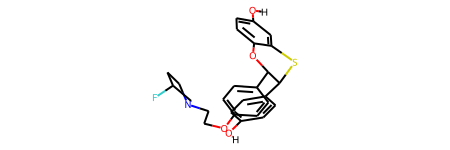

In [77]:
cp.iloc[0].Molecule

,minimizedAffinity,ID,Molecule
0,-9.54904,CMP_0,
1,-9.27619,CMP_0,
2,-8.71290,CMP_0,
3,-8.66961,CMP_0,
4,-8.66263,CMP_0,

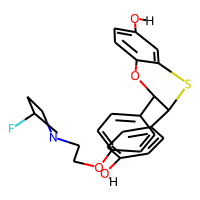
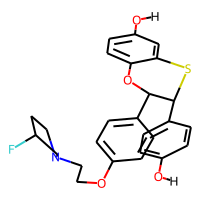
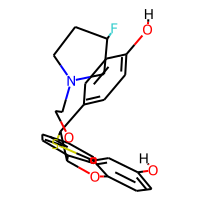
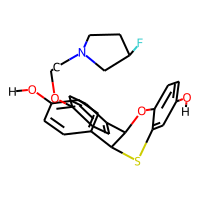
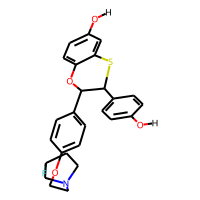

In [63]:
selecteddocked_df = PandasTools.LoadSDF('data/selected.sdf', molColName='Molecule', removeHs=False)
selecteddocked_df

In [79]:
!babel  -isdf 'selectedpose.sdf'  -osdf   -h  -O 'selectedposeH.sdf'

/bin/bash: babel: command not found


In [64]:
from rdkit.Chem import rdmolops 

In [80]:
mols = selecteddocked_df.Molecule.tolist()

In [81]:
def DrawDocking(protein,ligand):
     complex_pl = Chem.MolToPDBBlock(protein)
     docked_pdb = Chem.MolToPDBBlock(ligand)
     viewer = py3Dmol.view(width=800,height=800)
     viewer.addModel(complex_pl,'pdb')
     viewer.addModel(docked_pdb)
     prot = {'resn': ["DMS", "UNL", "SO4", "LIG", "HOH", "Cl"], 'invert': 1}  #define prot as all except list
     viewer.setStyle(prot,{'cartoon': {'colorscheme':'ssPyMol'}}) # Colour by secondary structure
     Lig_373 = {'resn' : 'LIG'} #original ligand in pdb file
     MyLig = {'resn':'UNL'} #ligand to be added from docking
     viewer.addSurface(py3Dmol.VDW,{'opacity':0.7, 'color': 'white'}, prot)
     viewer.setStyle({'resi': '132'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '147'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle({'resi': '311'}, {'stick': {'colorscheme': 'blueCarbon'}})
     viewer.setStyle(Lig_373,{'stick':{'colorscheme': 'whiteCarbon','radius':.1}}) 
     viewer.setStyle(MyLig,{'stick':{'colorscheme' : 'greenCarbon'}})
     viewer.zoomTo(MyLig)
     return viewer  

In [84]:
receptor = Chem.MolFromPDBFile('data/3ERT-receptor.pdb')
DrawDocking(receptor, mols[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

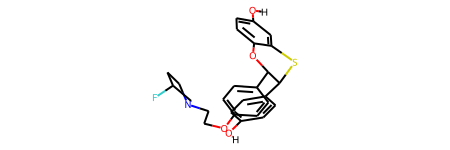

In [83]:
mols[0]